# Visualizations
The GBM data tools would be incomplete if we didn't provide a way to visualize the data.  We provide a number of different levels of plotting.  At the most basic level (and the level we hope you don't sink to), there is a library of plotting functions in `gbm.plot.lib`.  The next level up, we have plotting classes in `gbm.plot.gbmplot` which contain a variety of special plotting elements designed for the data tools. An example of one of these plot elements is a `Histo` class which, yes, plots a histogram. But it is special in that we want to plot histograms that may have gaps in it (i.e. SAA passage).  These plot elements can be added to a new plot with little effort as long as you instantiate them correctly.

At the highest level are plotting classes for specific views that can keep track of various plot elements in a single plot.  For example, plotting a lightcurve with a background model and signal selection requires us to keep track of `Histo`, `HistoErrorbars`, `LightcurveBackground`, and `HistoFilled` plot objects.  We'll show a few characteristics of how plotting works, but the full capability is somewhat limited in Jupyter.  If you are making plots in ipython, you can interactively modify the plots through the ipython environment.

---
## Lightcurves and Spectra
Let's revisit the example in the [PHA Export](./PhaExport.ipynb) tutorial:

In [1]:
from gbm import test_data_dir
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial

# some selections
erange = (8.0, 900.0)
bkgd_times = [(-20.0, -5.0), (75.0, 200.0)]
src_time = (6.0, 8.0)

# open TTE and bin
tte = TTE.open(test_data_dir+'/glg_tte_n9_bn090131090_v00.fit')
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)
lc_data = phaii.to_lightcurve(energy_range=erange)

# fit background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=1)
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
lc_bkgd = bkgd.integrate_energy(*erange)

# source selection
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

By default, the plot will show the full extent of the data

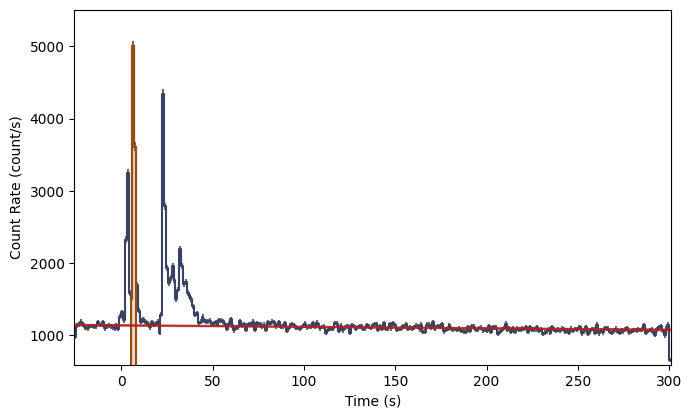

In [2]:
%matplotlib inline
from gbm.plot import Lightcurve

lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)

But you can adjust axis plot properties by setting them as attributes:

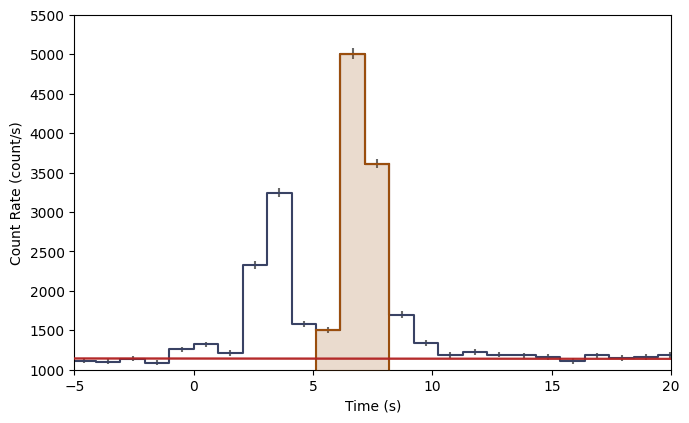

In [3]:
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = (-5.0, 20.0)
lcplot.ylim = (1000.0, 5500.)

You can access the various plot elements in the plot, also as attributes:

In [4]:
lcplot.lightcurve, lcplot.errorbars, lcplot.background, lcplot.selections

(<gbm.plot.gbmplot.Histo at 0x127b72910>,
 [<gbm.plot.gbmplot.HistoFilled at 0x127ae3f50>])

And each plot element has its own set of properties that can be modified.  Sometimes we may want to hide a plot element, or want to change the plot element's color or alpha.  You can retrieve this information as attributes, and you can set them like attributes as well.

In [5]:
print('Errorbars visible? {}'.format(lcplot.errorbars.visible))
print('Lightcurve color: {}'.format(lcplot.lightcurve.color))
print('Selection alpha: {}'.format(lcplot.selections[0].alpha))


Errorbars visible? True
Lightcurve color: #394264
Selection alpha: 0.2


Say we want to remove the errorbars, change the background model color to purple, and make the selection more opaque:

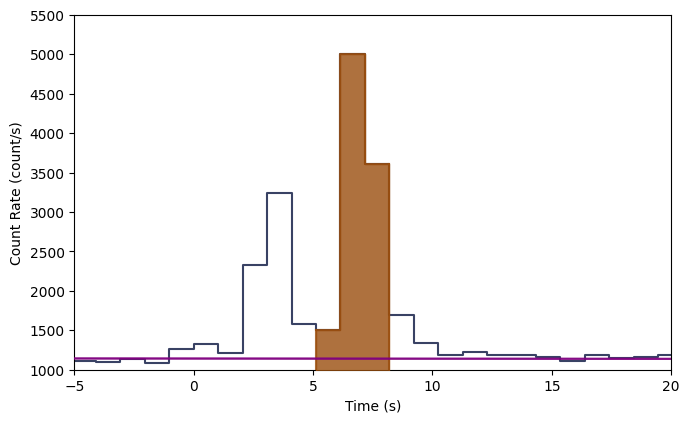

In [6]:
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = (-5.0, 20.0)
lcplot.ylim = (1000.0, 5500.)

lcplot.errorbars.hide()
lcplot.background.color='purple'
lcplot.selections[0].alpha=0.8

This is particularly elegant in ipython because you can perform these commands interactively without having to remake the whole plot.  Plotting the spectrum is similar:

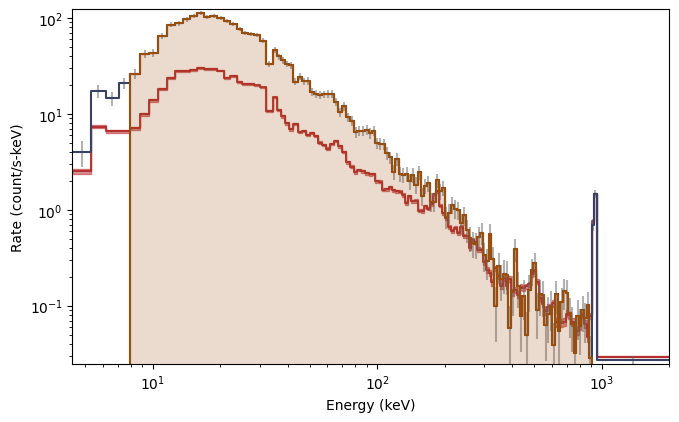

In [7]:
from gbm.plot import Spectrum

# our spectral data
spec_data = phaii.to_spectrum(time_range=src_time)
spec_bkgd = bkgd.integrate_time(*src_time)
spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)

specplot = Spectrum(data=spec_data, background=spec_bkgd)
specplot.add_selection(spec_selection)

You can set the scale in the plot much the same way you set the view ranges.  Plot the spectrum y-axis in linear scale (not sure why you would want to do this though):

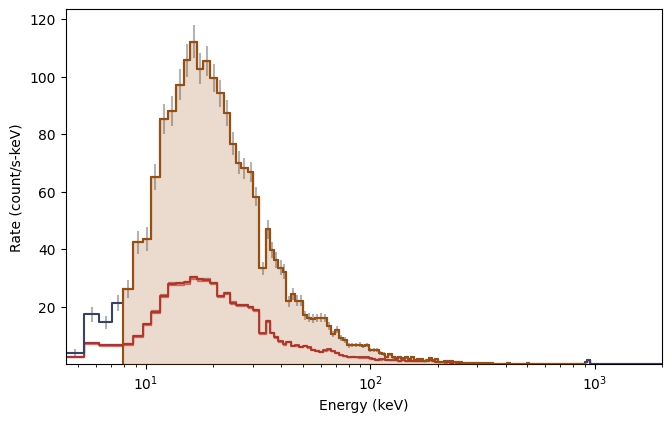

In [8]:
specplot = Spectrum(data=spec_data, background=spec_bkgd)
specplot.add_selection(spec_selection)
specplot.yscale = 'linear'

---
## Sky Maps

Sky map plots are usually used to show the GBM detector pointings and Earth occultation at a given time, or to show the GBM localization of an event on the sky.  They have more general functionality however, and you can use various plot elements to add to and customize your sky map plot.

Here's an example of how you might show the detector pointing for a single detector over the course of a day:

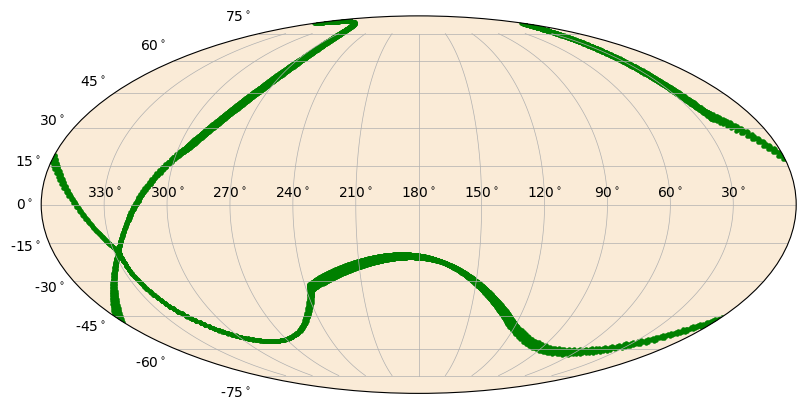

In [9]:
import numpy as np

from gbm.data import PosHist
from gbm.plot import SkyPlot
from gbm.plot.gbmplot import SkyPoints # plot element for plotting a single point or many points on the sky

# generate an array of times covering the poshist with frequency 1/minute 
poshist = PosHist.open(test_data_dir+'/glg_poshist_all_170101_v00.fit')
times = np.linspace(*poshist.time_range, 14400)

# detector RA, Dec pointings for each of our times
n0_ra, n0_dec = poshist.detector_pointing('n0', times)

s = SkyPlot() # initialize
# plot the points as green dots with marker size 5
pts = SkyPoints(n0_ra, n0_dec, s.ax, color='green', s=5)

Instead, we could plot the detector pointing as a continuous line.  Don't worry, the meridian clipping is already handled for you.

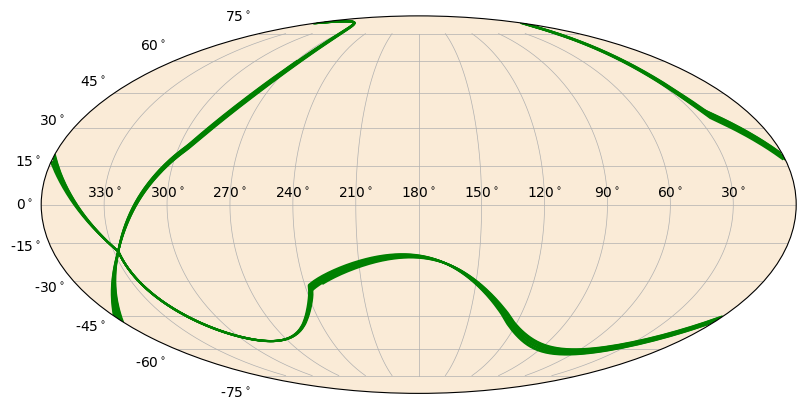

In [10]:
from gbm.plot.gbmplot import SkyLine # plot element for plotting a line on the sky
s = SkyPlot()
line = SkyLine(n0_ra, n0_dec, s.ax, color='green')


Similarly, you can plot circles on the sky of whatever size you want.  The Earth and detector pointing circles are special cases of the `SkyCircle` class.

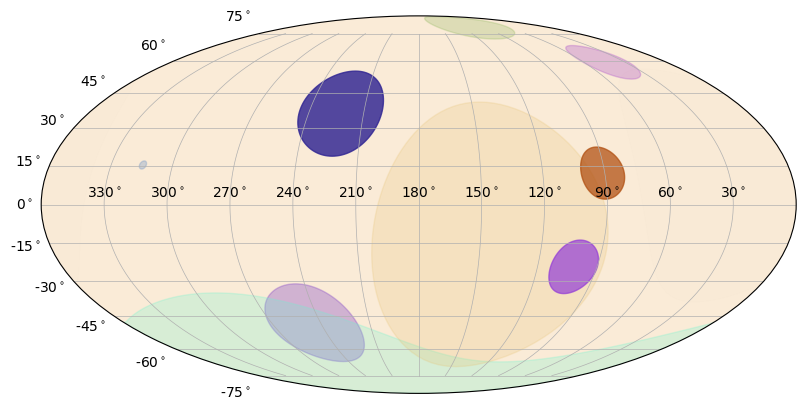

In [11]:
from gbm.plot.gbmplot import SkyCircle # plot element for plotting a (shaded) circle on the sky

ras = np.array([244.7, 289.6, 145.4, 104.27, 222.7, 101.6,  26.4, 44.1, 314.5, 91.0])
decs = np.array([-49., -74.0 , -14.3, 80.2, 36.9, -24.5 , 8.6,  59.6, 15.4,  12.3])
radii = np.random.uniform(1.0, 60.0, size=10)
colors = np.random.random(size=(10,4))

s = SkyPlot()
circles = [SkyCircle(ras[i], decs[i], radii[i], s.ax, color=colors[i,:]) for i in range(10)]

You can also plot polygons on the sky.  These are most useful for plotting confidence regions.

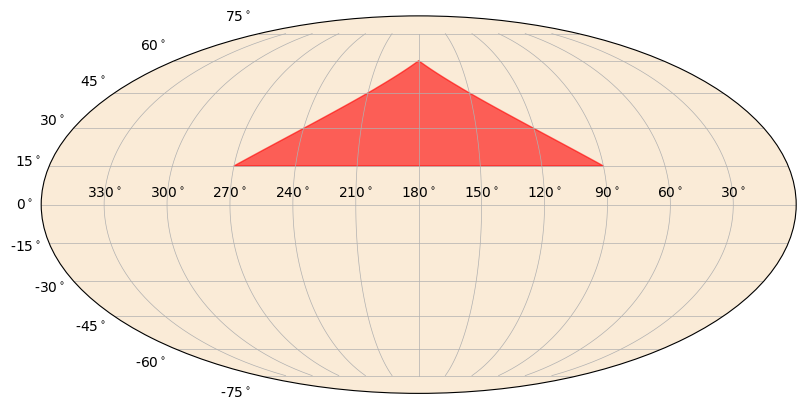

In [12]:
from gbm.plot.gbmplot import SkyPolygon # plot element for plotting a (shaded) polygon on the sky

ra_pts = np.array([270.0, 180.0, 90.0])
dec_pts = np.array([15.0, 60.0, 15.0])

s = SkyPlot()
poly = SkyPolygon(ra_pts, dec_pts, s.ax, color='red', alpha=0.6)

Another thing you can do is plot a heatmap on the sky.  This is essentially a color gradient that maps a parameter onto the sky, such as localization posterior density.

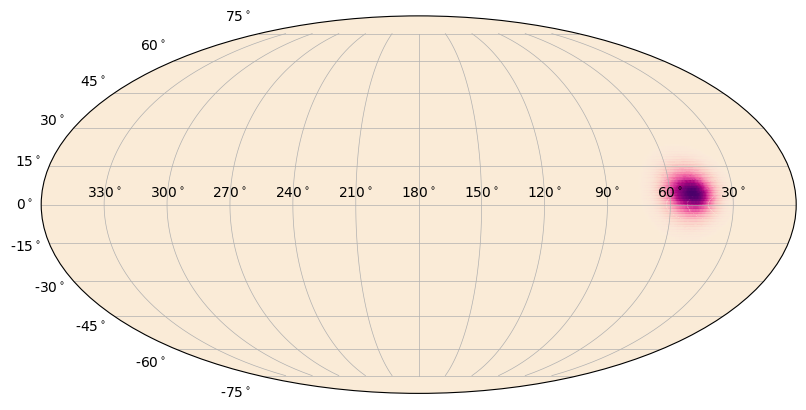

In [13]:
from gbm.data import GbmHealPix
from gbm.plot.gbmplot import SkyHeatmap

loc = GbmHealPix.open(test_data_dir+'/glg_healpix_all_bn190915240_v00.fit')

# converts the healpix grid to grid on the sky for plotting
prob, ra_grid, dec_grid = loc.prob_array(numpts_ra=720, numpts_dec=180)

s = SkyPlot()
heatmap = SkyHeatmap(ra_grid, dec_grid, prob, s.ax)

You can change the color of the heatmap, but this means you need to choose a *colormap* instead of just a color. Advanced users can create their own.  Additionally, you can add a normalization to the colormap that will change how the gradient is distributed.  Finally, you can adjust the alpha "gradient" of the map.  That is, lower heatmap values will become more transparent than higher heatmap values.  The default is to make this gradient go from 0 to 1, but that can be changed.

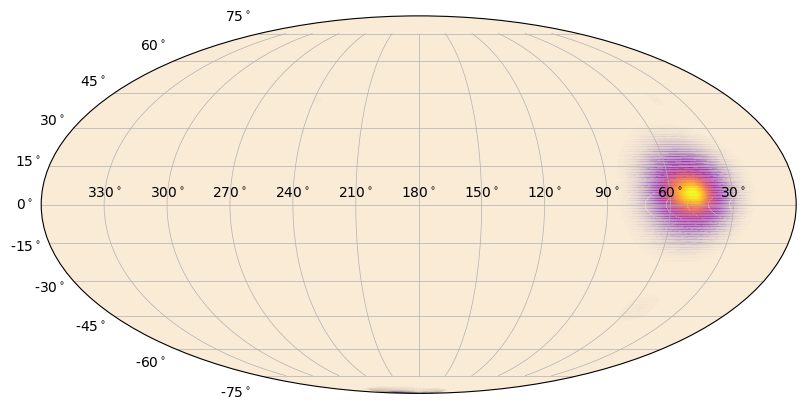

In [14]:
from matplotlib.colors import PowerNorm # power-law normalization for colormaps

# "plasma colormap with 0.3 power-law normalization"
s = SkyPlot()
heatmap = SkyHeatmap(ra_grid, dec_grid, prob, s.ax, color='plasma', norm=PowerNorm(0.3))

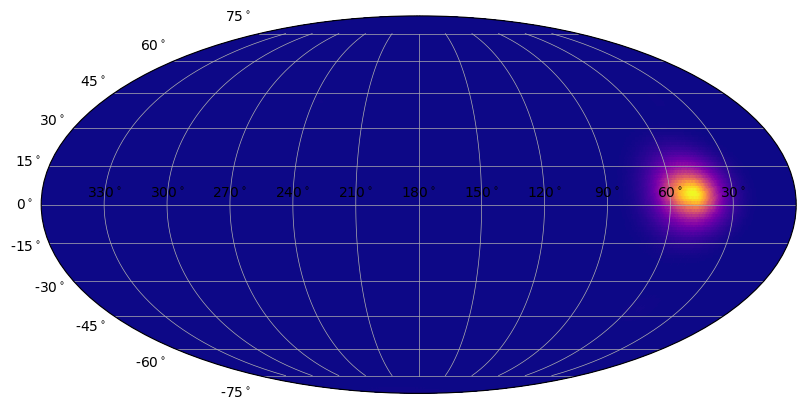

In [15]:
# and now defining alpha_min=1 (no alpha gradient)
s = SkyPlot()
heatmap = SkyHeatmap(ra_grid, dec_grid, prob, s.ax, color='plasma', norm=PowerNorm(0.3), alpha_min=1.0)

Ok, you should be getting the gist of it now.  For all the plot classes, you can add various plot elements or change their plotting properties, like color, alpha, plot symbols, etc.  For any of the plot classes, you can hide/show each plot element if you have its reference and modify various properties.  While we can demo this here, you should try this in ipython because you can see the plots update dynamically as you enter commands!